# Easy Money - Classification

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.model_selection import train_test_split

import xgboost as xgb

In [169]:
__DATA_PATH__ = "../data"
__INTERIM_DATA_PATH__ = f"{__DATA_PATH__}/interim"


TARGET = "debit_card"

DEV_PARTITION_PERIOD = ("2018-01-28", "2019-02-28")
VAL_PARTITION_PERIOD = ("2019-03-28", "2019-05-28")

# TRAIN_PERIOD = ("2018-01-28", "2018-12-28")
# TEST_PERIOD = ("2019-01-28", "2019-03-28")
# VALIDATION_PERIOD = ("2019-04-28", "2019-05-28")

exclude_columns = ["pk_cid", "pk_partition", "index"]

## Import data

In [170]:
df = pd.read_csv(f"{__INTERIM_DATA_PATH__}/easy_money_prep_1.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df.drop("entry_date", axis=1, inplace=True)
df["pk_partition"] = pd.to_datetime(df["pk_partition"])
df.shape

(5962838, 74)

## Filter data

In [171]:
df[["pk_cid", "pk_partition", TARGET]]

,pk_cid,pk_partition,debit_card
0,15891,2018-07-28,0
1,15891,2018-08-28,0
2,16063,2018-11-28,0
3,16063,2018-12-28,0
4,16063,2019-01-28,0
...,...,...,...
5962833,1553685,2019-05-28,0
5962834,1553686,2019-05-28,0
5962835,1553687,2019-05-28,0
5962836,1553688,2019-05-28,0


In [172]:
# gb_df = df.groupby("pk_cid")
#
# gb_df.agg(
#     em_acount_count=("em_acount", sum),
#     len=("em_acount", len)
# )

In [173]:
dfilter = df[df["pk_cid"] == 46327] #21719
dfilter[["pk_cid", "pk_partition", TARGET]]

,pk_cid,pk_partition,debit_card
1541,46327,2018-01-28,1
1542,46327,2018-02-28,1
1543,46327,2018-03-28,1
1544,46327,2018-04-28,1
1545,46327,2018-05-28,1
1546,46327,2018-06-28,1
1547,46327,2018-07-28,1
1548,46327,2018-08-28,1
1549,46327,2018-09-28,1
1550,46327,2018-10-28,1


In [174]:
dfilter

,pk_cid,pk_partition,active_customer,segment,region_code,gender,age,deceased,short_term_deposit,loans,...,country_id_PL,country_id_PT,country_id_QA,country_id_RO,country_id_RU,country_id_SA,country_id_SE,country_id_SN,country_id_US,country_id_VE
1541,46327,2018-01-28,1,2,28,1,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1542,46327,2018-02-28,1,2,28,1,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1543,46327,2018-03-28,1,2,28,1,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1544,46327,2018-04-28,1,2,28,1,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1545,46327,2018-05-28,1,2,28,1,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1546,46327,2018-06-28,1,2,28,1,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1547,46327,2018-07-28,1,2,28,1,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1548,46327,2018-08-28,1,2,28,1,66,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1549,46327,2018-09-28,1,2,28,1,66,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1550,46327,2018-10-28,1,2,28,1,66,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
first_sale = df.reset_index().groupby(["pk_cid", TARGET]).first().reset_index()
first_sale = first_sale[first_sale[TARGET] == 1]
first_sale

,pk_cid,debit_card,index,pk_partition,active_customer,segment,region_code,gender,age,deceased,...,country_id_PL,country_id_PT,country_id_QA,country_id_RO,country_id_RU,country_id_SA,country_id_SE,country_id_SN,country_id_US,country_id_VE
5,17457,1,32,2018-09-28,1,1,28,1,53,0,...,0,0,0,0,0,0,0,0,0,0
8,17970,1,69,2018-01-28,1,1,28,0,75,0,...,0,0,0,0,0,0,0,0,0,0
20,20333,1,225,2018-01-28,1,1,28,1,48,0,...,0,0,0,0,0,0,0,0,0,0
25,21719,1,294,2018-05-28,1,1,28,1,56,0,...,0,0,0,0,0,0,0,0,0,0
27,22212,1,322,2019-04-28,1,1,24,0,53,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502895,1550901,1,5960690,2019-05-28,1,0,11,0,34,0,...,0,0,0,0,0,0,0,0,0,0
502984,1551017,1,5960779,2019-05-28,1,0,2,1,50,0,...,0,0,0,0,0,0,0,0,0,0
503304,1551424,1,5961099,2019-05-28,1,0,21,0,33,0,...,0,0,0,0,0,0,0,0,0,0
503437,1551599,1,5961232,2019-05-28,0,0,20,0,37,0,...,0,0,0,0,0,0,0,0,0,0


In [176]:
last_no_sale = df.reset_index().groupby(["pk_cid", TARGET]).last().reset_index()
last_no_sale = last_no_sale[last_no_sale[TARGET] == 0]
last_no_sale

,pk_cid,debit_card,index,pk_partition,active_customer,segment,region_code,gender,age,deceased,...,country_id_PL,country_id_PT,country_id_QA,country_id_RO,country_id_RU,country_id_SA,country_id_SE,country_id_SN,country_id_US,country_id_VE
0,15891,0,1,2018-08-28,0,1,28,1,59,0,...,0,0,0,0,0,0,0,0,0,0
1,16063,0,8,2019-05-28,0,1,28,1,62,0,...,0,0,0,0,0,0,0,0,0,0
2,16203,0,14,2019-05-28,1,3,8,0,70,0,...,0,0,0,0,0,0,0,0,0,0
3,16502,0,23,2019-05-28,1,1,28,1,58,0,...,0,0,0,0,0,0,0,0,0,0
4,17457,0,39,2019-04-28,1,1,28,1,54,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505038,1553685,0,5962833,2019-05-28,0,0,13,0,52,0,...,0,0,0,0,0,0,0,0,0,0
505039,1553686,0,5962834,2019-05-28,0,0,41,1,30,0,...,0,0,0,0,0,0,0,0,0,0
505040,1553687,0,5962835,2019-05-28,0,0,28,0,21,0,...,0,0,0,0,0,0,0,0,0,0
505041,1553688,0,5962836,2019-05-28,0,0,39,1,43,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
df_prep = pd.concat([first_sale, last_no_sale]).sort_values(["pk_cid", "pk_partition"], ignore_index=True)
df_prep

,pk_cid,debit_card,index,pk_partition,active_customer,segment,region_code,gender,age,deceased,...,country_id_PL,country_id_PT,country_id_QA,country_id_RO,country_id_RU,country_id_SA,country_id_SE,country_id_SN,country_id_US,country_id_VE
0,15891,0,1,2018-08-28,0,1,28,1,59,0,...,0,0,0,0,0,0,0,0,0,0
1,16063,0,8,2019-05-28,0,1,28,1,62,0,...,0,0,0,0,0,0,0,0,0,0
2,16203,0,14,2019-05-28,1,3,8,0,70,0,...,0,0,0,0,0,0,0,0,0,0
3,16502,0,23,2019-05-28,1,1,28,1,58,0,...,0,0,0,0,0,0,0,0,0,0
4,17457,1,32,2018-09-28,1,1,28,1,53,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505038,1553685,0,5962833,2019-05-28,0,0,13,0,52,0,...,0,0,0,0,0,0,0,0,0,0
505039,1553686,0,5962834,2019-05-28,0,0,41,1,30,0,...,0,0,0,0,0,0,0,0,0,0
505040,1553687,0,5962835,2019-05-28,0,0,28,0,21,0,...,0,0,0,0,0,0,0,0,0,0
505041,1553688,0,5962836,2019-05-28,0,0,39,1,43,0,...,0,0,0,0,0,0,0,0,0,0


In [178]:
def plot(dataframe: pd.DataFrame, target: str):
    dataframe[target].hist()
    plt.show()
    print(target)
    print(dataframe[target].value_counts())

## Target distribution

In [179]:
df_prep[TARGET].describe()

count    505043.000000
mean          0.125799
std           0.331623
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: debit_card, dtype: float64

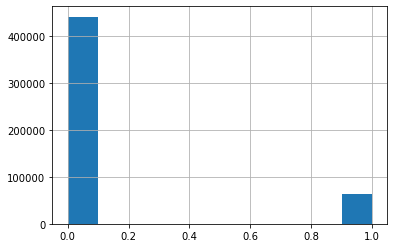

debit_card
0    441509
1     63534
Name: debit_card, dtype: int64


In [180]:
plot(df_prep, TARGET)

<AxesSubplot:xlabel='region_code', ylabel='count'>

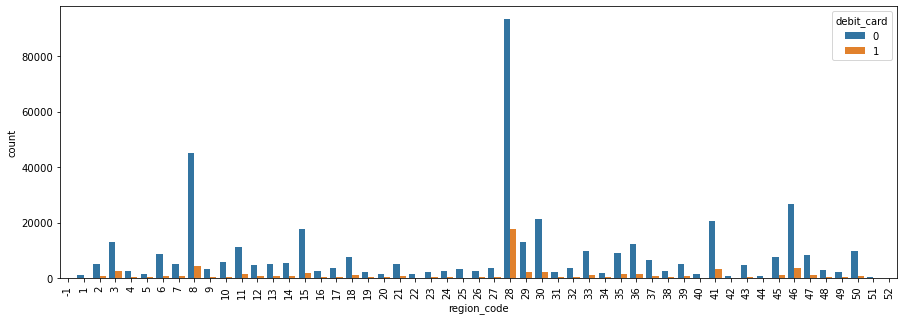

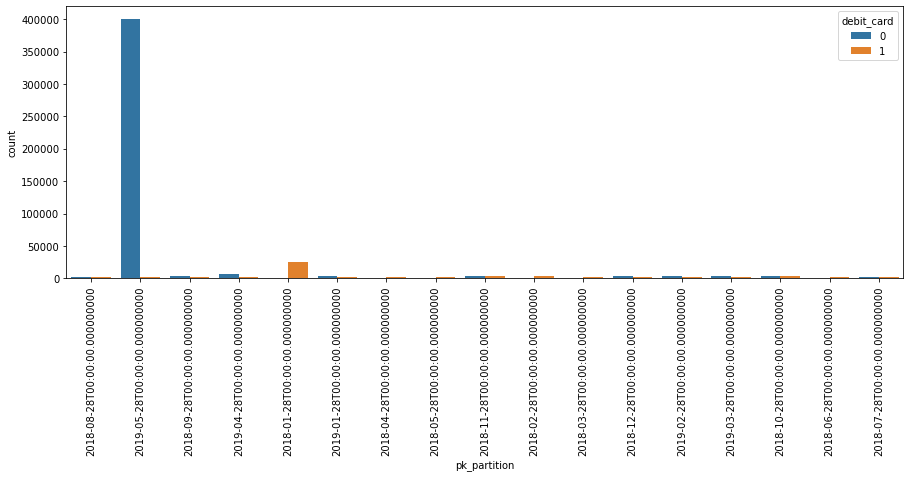

,len,sum,mean
,debit_card,debit_card,debit_card
pk_partition,,,
2018-01-28,25509,24696,0.968129
2018-02-28,4641,3708,0.798966
2018-03-28,3479,2691,0.773498
2018-04-28,2856,2121,0.742647
2018-05-28,2643,1803,0.682179
2018-06-28,2706,1834,0.677753
2018-07-28,3965,1942,0.489786
2018-08-28,4479,1943,0.433802


In [213]:
def relation_with_target(dataframe: pd.DataFrame, field: str, target: str):
    plt.figure(figsize=(15,5))
    plt.xticks(rotation=90)
    sns.countplot(data=dataframe, x=field, hue=target)
    plt.show()
    return dataframe.pivot_table(index=field, values=target, aggfunc=[len, sum, np.mean])

relation_with_target(df_prep, "pk_partition", TARGET)

## split dataframes

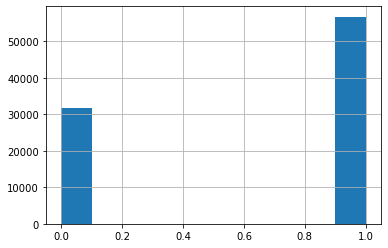

debit_card
1    56766
0    31628
Name: debit_card, dtype: int64


In [181]:
train_df = df_prep[df_prep["pk_partition"].between(DEV_PARTITION_PERIOD[0], DEV_PARTITION_PERIOD[1])].reset_index(drop=True)
train_df = train_df.drop(exclude_columns, axis=1)
plot(train_df, TARGET)

In [182]:
train_df

,debit_card,active_customer,segment,region_code,gender,age,deceased,short_term_deposit,loans,mortgage,...,country_id_PL,country_id_PT,country_id_QA,country_id_RO,country_id_RU,country_id_SA,country_id_SE,country_id_SN,country_id_US,country_id_VE
0,0,0,1,28,1,59,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,28,1,53,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,28,0,75,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,28,1,53,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,28,1,48,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88389,0,0,0,21,0,79,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88390,0,0,0,3,0,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88391,0,0,0,28,0,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88392,0,0,0,46,1,36,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
# test_df = df_prep[df_prep["pk_partition"].between(TEST_PERIOD[0], TEST_PERIOD[1])]
# plot(test_df, TARGET)

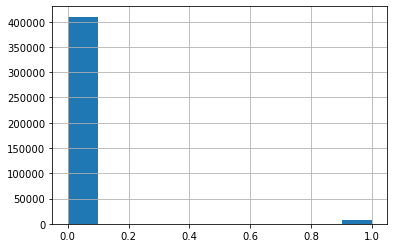

debit_card
0    409881
1      6768
Name: debit_card, dtype: int64


In [184]:
validation_df = df_prep[df_prep["pk_partition"].between(VAL_PARTITION_PERIOD[0], VAL_PARTITION_PERIOD[1])].reset_index(drop=True)
validation_df = validation_df.drop(exclude_columns, axis=1)
plot(validation_df, TARGET)

In [185]:
dev_X = train_df.drop(TARGET, axis=1)
dev_y = train_df[[TARGET]]

val_X = validation_df.drop(TARGET, axis=1)
val_y = validation_df[[TARGET]]

In [186]:
dev_X

,active_customer,segment,region_code,gender,age,deceased,short_term_deposit,loans,mortgage,funds,...,country_id_PL,country_id_PT,country_id_QA,country_id_RO,country_id_RU,country_id_SA,country_id_SE,country_id_SN,country_id_US,country_id_VE
0,0,1,28,1,59,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,28,1,53,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,28,0,75,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,28,1,53,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,28,1,48,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88389,0,0,21,0,79,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88390,0,0,3,0,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88391,0,0,28,0,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88392,0,0,46,1,36,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
# def dev_val_split(dataframe: pd.DataFrame, split_condition, exclude_columns, target: str = TARGET):
#     dev_df = dataframe[split_condition].drop(exclude_columns, axis=1)
#     val_df = dataframe[~split_condition].drop(exclude_columns, axis=1)
#
#     dev_df_X = dev_df.drop(target, axis=1)
#     dev_df_y = dev_df[[TARGET]]
#
#     val_df_X = val_df.drop(TARGET, axis=1)
#     val_df_y = val_df[[TARGET]]
#
#     print(f"""
#         dev_df_X.shape: {dev_df_X.shape}
#         dev_df_y.shape: {dev_df_y.shape}
#
#         val_df_X.shape: {val_df_X.shape}
#         val_df_y.shape: {val_df_y.shape}
#     """)
#
#     return dev_df_X, dev_df_y, val_df_X, val_df_y
#
#
# dev_df_X, dev_df_y, val_df_X, val_df_y = dev_val_split(
#     dataframe=df,
#     split_condition=(df["pk_partition"] < "2019-03-28"),
#     exclude_columns=["pk_cid", "pk_partition", "entry_date"],
#     target=TARGET
# )

In [188]:
X_train, X_test, y_train, y_test = train_test_split(
    dev_X,
    dev_y,
    test_size=0.2,
    random_state=13,
    stratify=dev_y
)
print(f"""
X_train.shape: {X_train.shape}
X_test.shape: {X_test.shape}
y_train.shape: {y_train.shape}
y_test.shape: {y_test.shape}
""")


X_train.shape: (70715, 71)
X_test.shape: (17679, 71)
y_train.shape: (70715, 1)
y_test.shape: (17679, 1)



## Modelling

In [189]:
_MAX_DEPTH = 4
_MIN_SAMPLES_LEAF = 100
_RANDOM_STATE = 42


_MIN_CHILD_WEIGHT = 100
_N_ESTIMATORS = 50

In [190]:
model = xgb.XGBClassifier(
    max_depth=_MAX_DEPTH,
    min_child_weight=_MIN_CHILD_WEIGHT,
    n_estimators=_N_ESTIMATORS,
    random_state=_RANDOM_STATE,
    use_label_encoder=False
)

In [191]:
model.fit(X_train, y_train)

[00:47:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=100, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [192]:
accuracy = round(model.score(val_X, val_y), 4)
print('Accuracy: %0.4f' % (accuracy))

Accuracy: 0.3564


<AxesSubplot:>

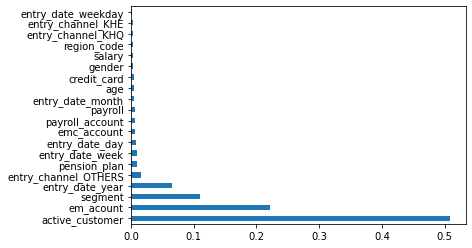

In [193]:
feat_importances = pd.Series(model.feature_importances_, index=dev_X.columns)
feat_importances.nlargest(20).plot(kind='barh')